# Analysis

Take information generated in [main](./main.ipynb) and run some analysis on it. This is either sanity checks that the code is doing what we expect or comparisons to the literature.

A summary:

Some sections assume you have loaded the data in section 2. Some don't `¯\_(ツ)_/¯`.
* Magnitude gap: Plot the difference in mass between the central and the largest satellite in large galaxies. A large magnitude gap implies it is easy to pick out the central in a cluster. A small (or negative) magnitude gap makes this hard. It seems pretty small to me!
* Scatter SMHM in Mock: Plot the scatter in SM at fixed HM in the mock. Compare this to CB in prep from the UM. Pretty similar - pretty cool!
* 2pcf: Compare our projected two point correlation function to that in a [Tinker paper](https://arxiv.org/pdf/1607.04678.pdf). Pretty similar!
* Satellite Fraction: Plot the sat frac computed in the MCMC and compare that to the UM ASAP model + a number of literature models. Some variance between models here.

## Imports etc

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

import clustering as c
import data as d

import sat_fraction
import halotools.mock_observables
%run ~/.jupyter/config.ipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

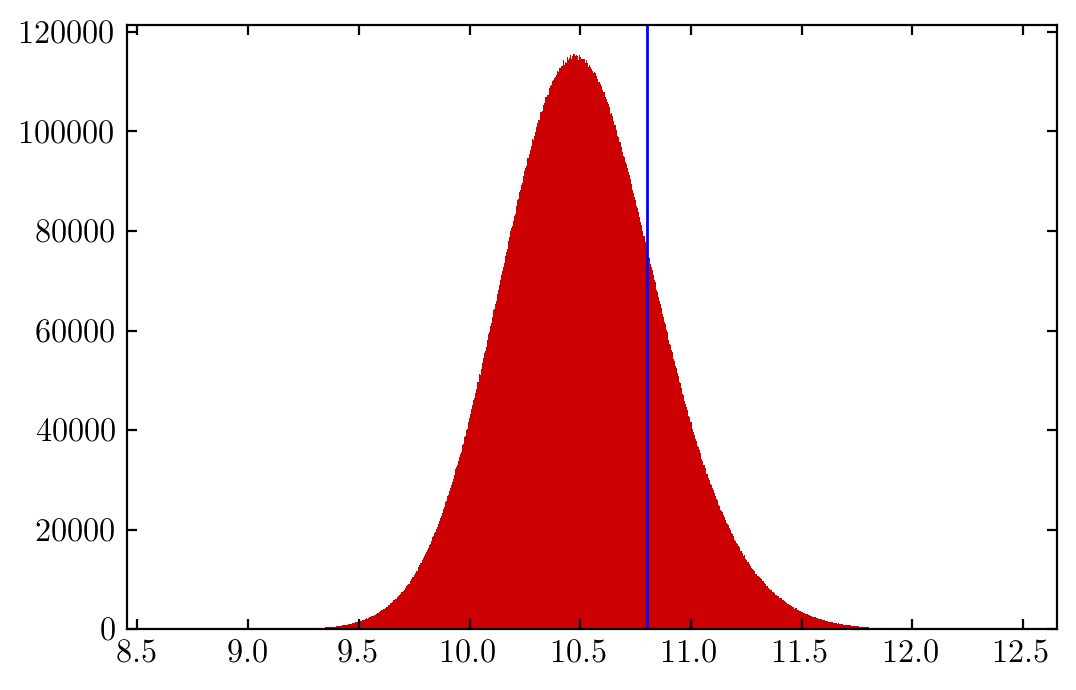

In [17]:
use_vmax = True
if use_vmax:
    sim_data, cens, sats, sim_data_complete, cens_complete, sats_complete, sim_size = d.load_mock("mocks/vmax.npy", 10**10.8, plot_completeness=True)
else:
    sim_data, cens, sats, sim_data_complete, cens_complete, sats_complete, sim_size = d.load_mock("mocks/mpeak.npy", 10**10.8, plot_completeness=True)

# Mag gap

In [13]:
s_cens = np.sort(cens_complete[
    cens_complete["Mpeak"] > 10**14.3 # At lower masses some halos don't have satellites (above the completeness cut we made earlier).
], order="id")

In [14]:
s_sats = np.sort(sats_complete, order=["upid", "stellar_mass"])
idx = np.searchsorted(s_sats["upid"], s_cens["id"], side="right") - 1

assert np.all(s_sats[idx]["upid"] == s_cens["id"])
s_sats = s_sats[idx]
# We now have a bunch of cens and the largest sat in some of the largest halos.

0.7462536345336613


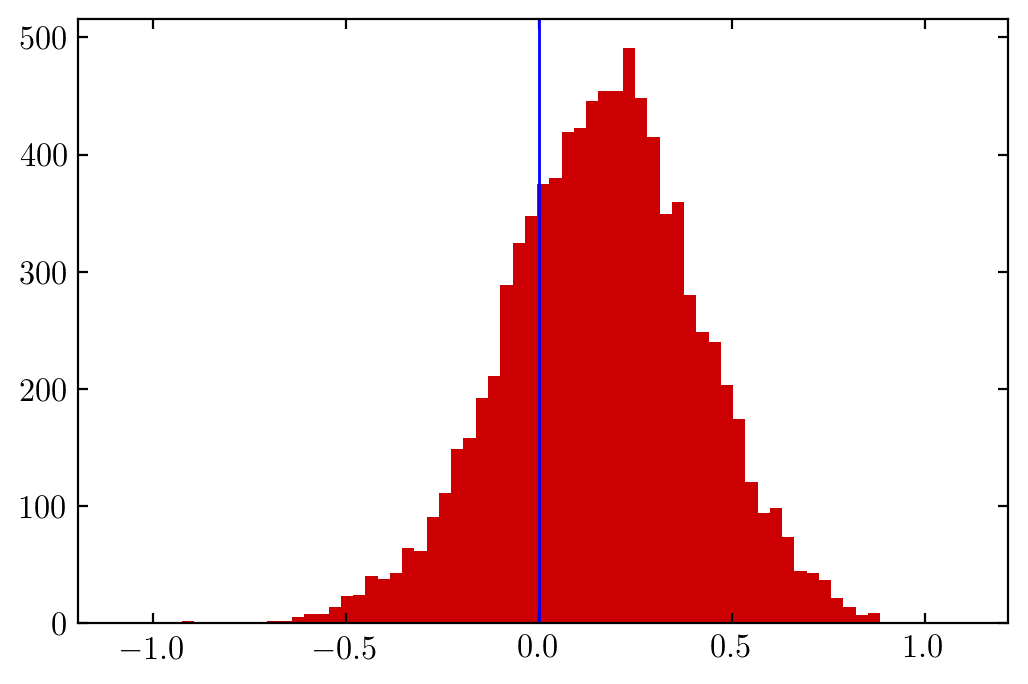

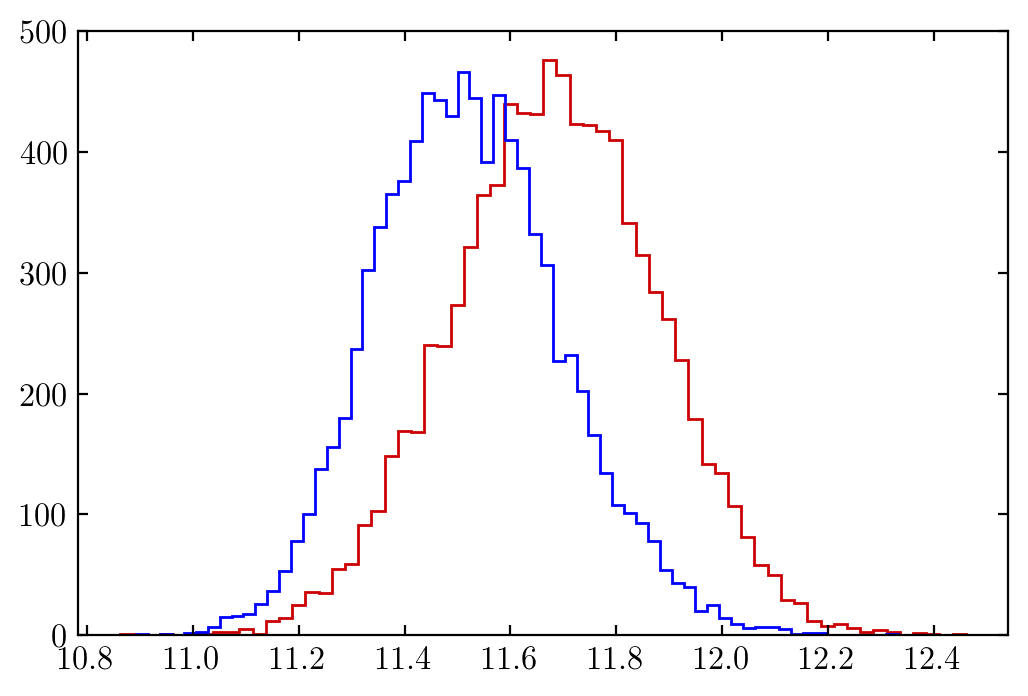

In [15]:
fig, ax = plt.subplots()
ax.hist(
    np.log10(s_cens["stellar_mass"]) - np.log10(s_sats["stellar_mass"])
)
ax.axvline(0, color="blue")
fig.savefig("/home/christopher/research/satellite_fraction/cb/writeup/images/mag_gap1.png", dpi=300)
print(np.count_nonzero(
    np.log10(s_cens["stellar_mass"]) > np.log10(s_sats["stellar_mass"])
)/len(s_cens))

fig, ax = plt.subplots()
ax.hist(np.log10(s_cens["stellar_mass"]), label="cen", histtype='step')
ax.hist(np.log10(s_sats["stellar_mass"]), label="sats", histtype='step')
fig.savefig("/home/christopher/research/satellite_fraction/cb/writeup/images/mag_gap2.png", dpi=300)

# Satellite Fraction

In [3]:
bins = np.append(
    np.linspace(11.5, 11.9, num=9),
    np.linspace(12, 12.2, num=4),
)
bin_centers = bins[:-1] + np.diff(bins)/2

_, um_cens_comp, um_sats_comp, _ = d.load_asap_um("./mocks/asap_smdpl_mock_default.fits", 11)

In [24]:
vmax_sat_frac = np.load("intermediate_data/Vmax@Mpeak/sat_frac.npz")
mpeak_sat_frac = np.load("intermediate_data/Mpeak/sat_frac.npz")

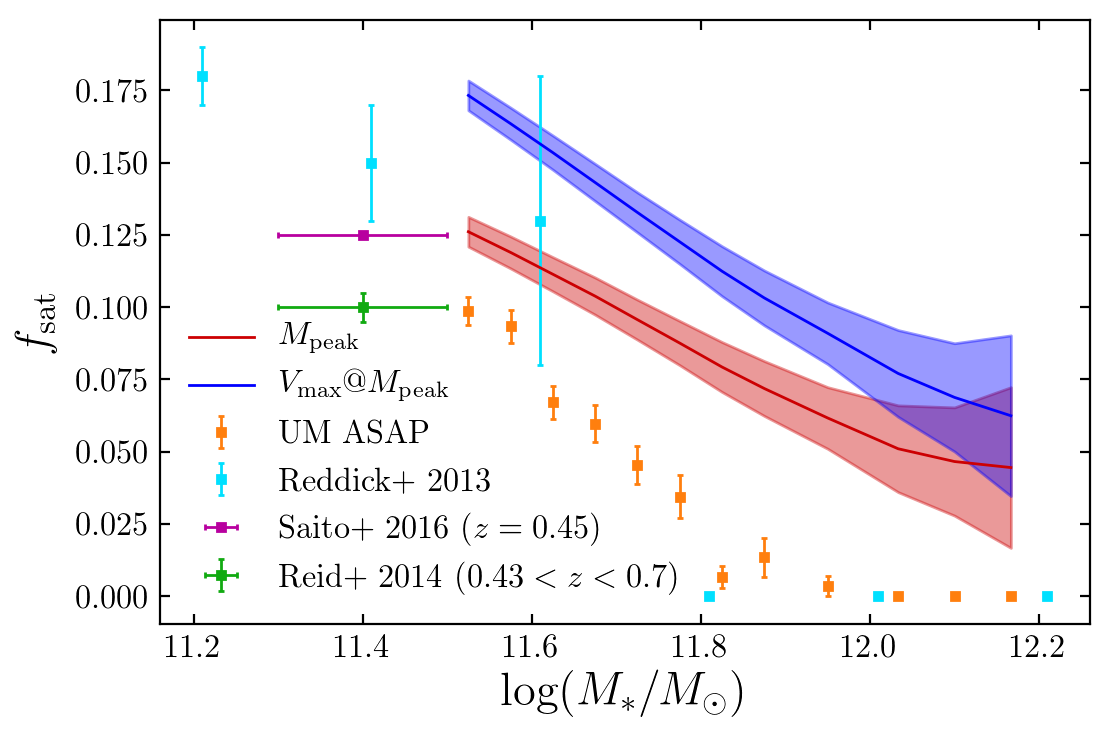

In [38]:
reddick_bin_centers, reddick_sat_frac, reddick_sat_frac_unc = sat_fraction.reddick()
saito_bin_centers, saito_sat_frac, saito_mass_error = sat_fraction.saito()
reid_bin_centers, reid_sat_frac, reid_mass_error, reid_sat_frac_unc = sat_fraction.reid()


um_sat_frac, um_sat_frac_unv = sat_fraction.ASAP_UM(um_cens_comp, um_sats_comp, bins)

fig, ax = plt.subplots()

for (s, l) in [(mpeak_sat_frac, r"$M_{\rm peak}$"), (vmax_sat_frac, r"$V_{\rm max}@M_{\rm peak}$")]:
    x, y, err = s["bin_centers"], np.mean(s["sat_fraction"], axis=0), np.std(vmax_sat_frac["sat_fraction"], axis=0)
    l = ax.plot(x, y, label=l)
    ax.fill_between(x, y+err, y-err, color=l[0].get_color(), alpha=0.4)

ax.errorbar(bin_centers, um_sat_frac, yerr=um_sat_frac_unv, ls="None", marker="s", label="UM ASAP")
ax.errorbar(reddick_bin_centers, reddick_sat_frac, yerr=reddick_sat_frac_unc, ls="None", marker="s", label="Reddick+ 2013")
ax.errorbar(saito_bin_centers, saito_sat_frac, xerr=saito_mass_error, ls="None", marker="s", label="Saito+ 2016 ($z = 0.45$)")
ax.errorbar(reid_bin_centers, reid_sat_frac, xerr=reid_mass_error, yerr=reid_sat_frac_unc, ls="None", marker="s", label="Reid+ 2014 ($0.43 < z < 0.7$)")



ax.legend(fontsize="small", loc="lower left")
ax.set(ylabel=r"$f_{\rm sat}$", xlabel=r"${\rm log} (M_{\ast} / M_{\odot})$")
fig.savefig("/home/christopher/research/satellite_fraction/cb/writeup/images/sat_frac.png", dpi=300)

# Scatter SMHM in Mock

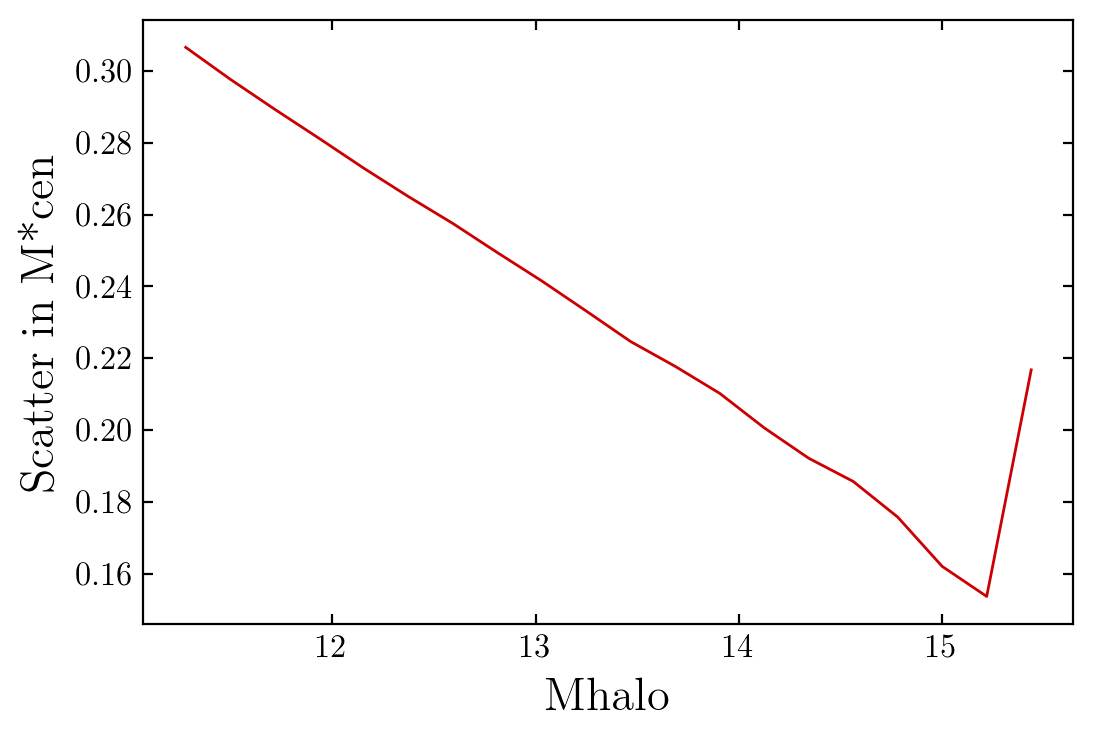

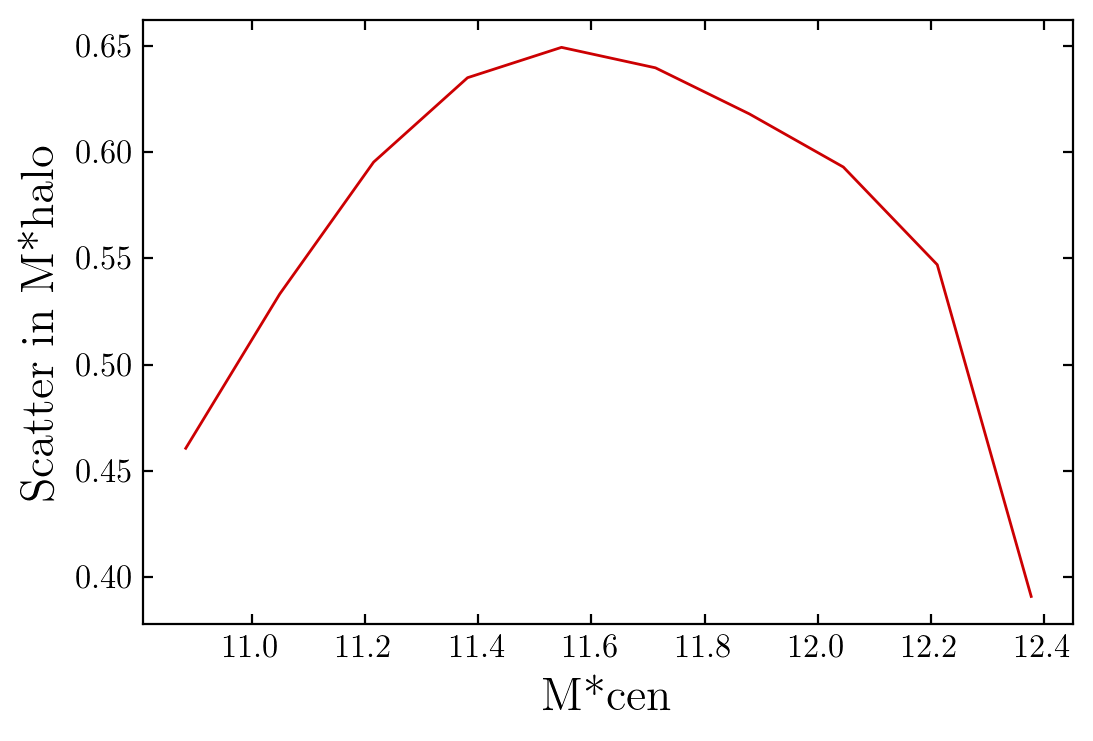

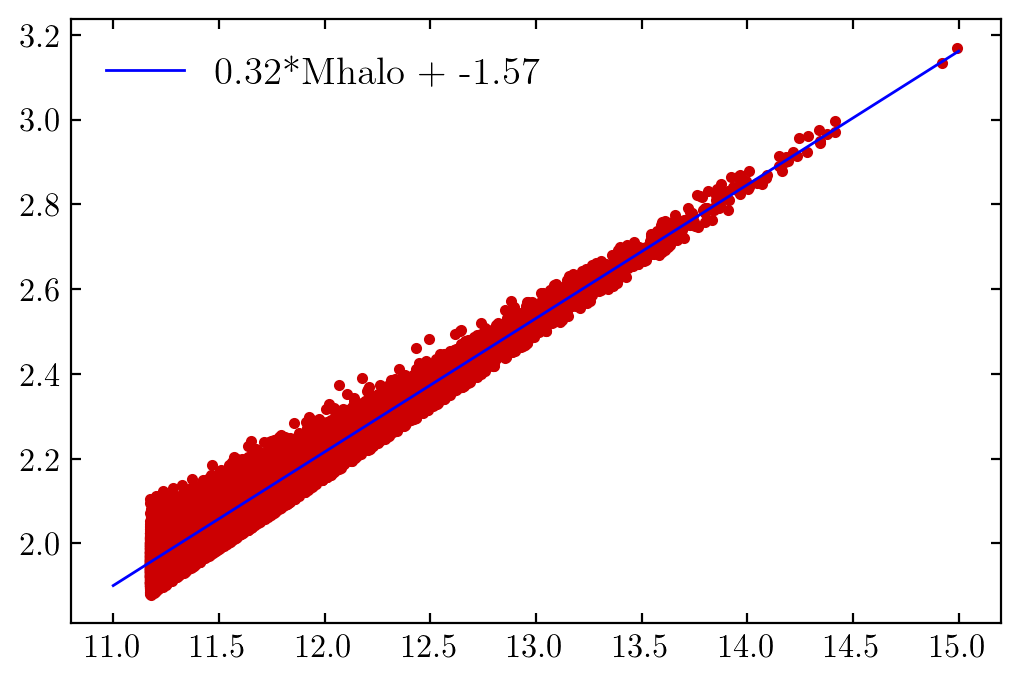

In [18]:
scatter, bin_edges, _ = scipy.stats.binned_statistic(
    np.log10(cens["Mpeak"]), 
    np.log10(cens["stellar_mass"]), 
    np.std,
    bins=20,
)
bin_centers = bin_edges[1:] - np.diff(bin_edges)/2

fig, ax = plt.subplots()
ax.plot(bin_centers, scatter)
ax.set(ylabel="Scatter in M*cen", xlabel="Mhalo")
fig.savefig("/home/christopher/research/satellite_fraction/cb/writeup/images/scatter_mcen_mhalo.png", dpi=300)


# Exactly the same, just the other way around
scatter, bin_edges, _ = scipy.stats.binned_statistic(
    np.log10(cens_complete["stellar_mass"]), 
    np.log10(cens_complete["Mpeak"]), 
    np.std,
    bins=10,
)
bin_centers = bin_edges[1:] - np.diff(bin_edges)/2

_, ax = plt.subplots()
ax.plot(bin_centers, scatter)
ax.set(ylabel="Scatter in M*halo", xlabel="M*cen")

# And explaining why scatter in M*cen at fixed Mhalo is linear -
# Mhalo is linear with Vmax which is what we conditioned on
fig, ax = plt.subplots()
ax.scatter(
    np.log10(cens["Mpeak"][::1000]),
    np.log10(cens["Vmax@Mpeak"][::1000]),
)
regress = scipy.stats.linregress(np.log10(cens["Mpeak"]), np.log10(cens["Vmax@Mpeak"]))
mhalo = np.array([11, 15])
ax.plot(mhalo, regress.slope * mhalo + regress.intercept, color="blue", label="{:.2f}*Mhalo + {:.2f}".format(regress.slope, regress.intercept))
ax.legend()
fig.savefig("/home/christopher/research/satellite_fraction/cb/writeup/images/mhalo_vs_vmax.png", dpi=300)

# 2pcf

We want to compare ours to this tinker paper https://arxiv.org/pdf/1607.04678.pdf

In [5]:
r_bins = np.geomspace(0.4, 40, num=8)
r_bins_cen = 10**( (np.log10(r_bins[:-1]) + np.log10(r_bins[1:])) / 2 )
sm_bins = [11.6, 11.7, 11.8, 11.9]

/home/christopher/.virtualenvs/greg/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.
  


Units of stellar mass are in M*


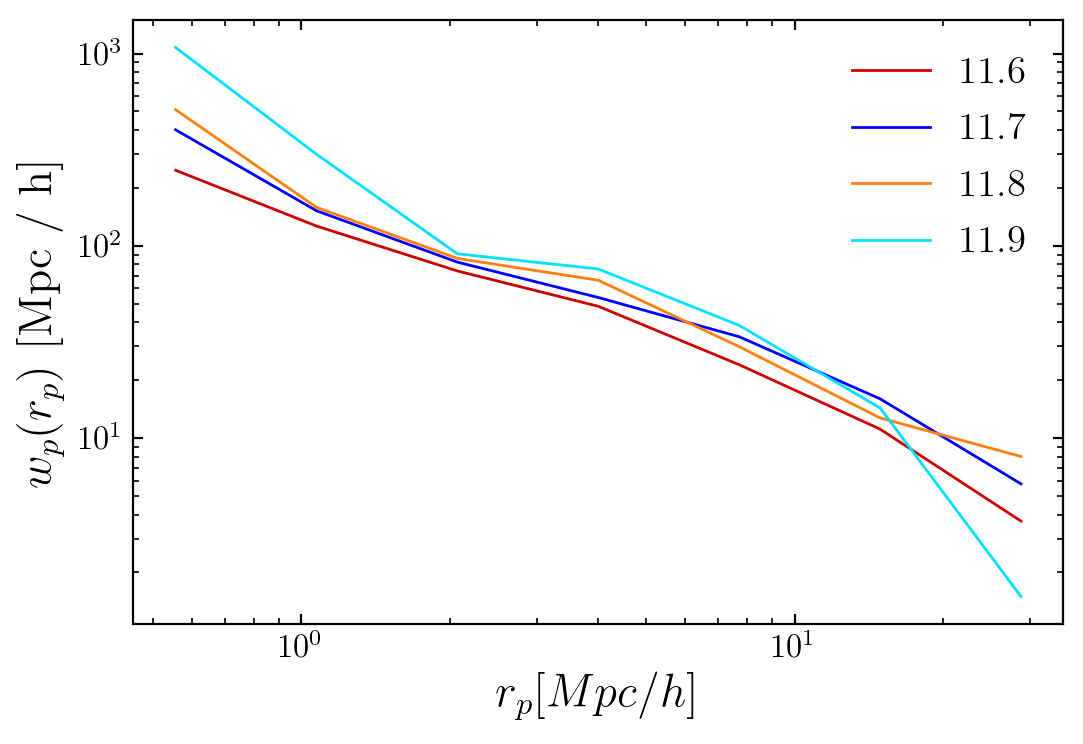

In [21]:
fig, ax = plt.subplots()

for sm in sm_bins:
    cut = sim_data_complete[
        (sim_data_complete["stellar_mass"] > 10**(sm-0.05)) &
        (sim_data_complete["stellar_mass"] < 10**(sm+0.05))
    ]
    s1 = cut[["halo_x", "halo_y", "halo_z"]].view(np.float64).reshape((-1, 3))
    assert s1[0][0] == cut[0]["halo_x"] # view is scary

    wp_rp = halotools.mock_observables.wp(s1, r_bins, 300, period=sim_size, estimator="Landy-Szalay")
    ax.plot(r_bins_cen, wp_rp, label=sm)
    
ax.set(yscale="log", xscale="log", ylabel=r"$w_p(r_p)$ [Mpc / h]", xlabel="$r_p [Mpc / h]$")
ax.legend()
print("Units of stellar mass are in M*")

fig.savefig("/home/christopher/research/satellite_fraction/cb/writeup/images/2pcf.png", dpi=300)

/home/christopher/.virtualenvs/greg/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.
  
/home/christopher/.virtualenvs/greg/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.
  if __name__ == '__main__':


63405 12570
Units of stellar mass are in M*


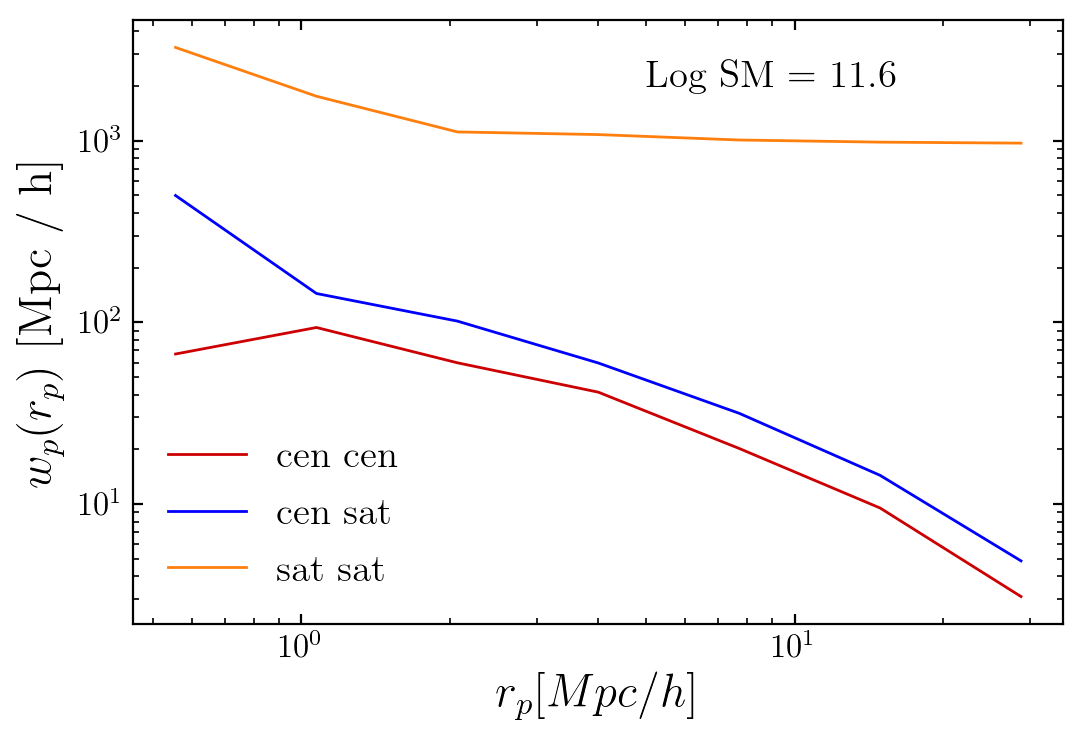

In [28]:
fig, ax = plt.subplots()
sm = 11.6

cut = sim_data_complete[
    (sim_data_complete["stellar_mass"] > 10**(sm-0.05)) &
    (sim_data_complete["stellar_mass"] < 10**(sm+0.05))
]
s_cens = cut[cut["upid"] == -1][["halo_x", "halo_y", "halo_z"]].view(np.float64).reshape((-1, 3))
s_sats = cut[cut["upid"] != -1][["halo_x", "halo_y", "halo_z"]].view(np.float64).reshape((-1, 3))

#s_cens = np.random.permutation(s_cens.flatten()).reshape((-1, 3))
#s_sats = np.random.permutation(s_sats.flatten()).reshape((-1, 3))
print(len(s_cens), len(s_sats))
wp_rp = halotools.mock_observables.wp(s_cens, r_bins, 300, s_sats, period=sim_size, estimator="Landy-Szalay")
for i, legend in enumerate(["cen cen", "cen sat", "sat sat"]):
    ax.plot(r_bins_cen, wp_rp[i], label=legend)

ax.annotate("Log SM = {}".format(sm), (5, 2000))
    
ax.set(yscale="log", xscale="log", ylabel=r"$w_p(r_p)$ [Mpc / h]", xlabel="$r_p [Mpc / h]$")
ax.legend()
print("Units of stellar mass are in M*")

#fig.savefig("/home/christopher/research/satellite_fraction/cb/writeup/images/2pcf.png", dpi=300)